<a href="https://colab.research.google.com/github/cdebom/AstroStatistic2022class/blob/main/cre4at_cloudseg_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1p86DXzs1ydjMlc217kALGjYqFi0Cbr32' width=400 height=200 align="left" />
</figure>

# MÉTODOS PARA ANÁLISE DE GRANDES VOLUMES DE DADOS E ASTROINFORMÁTICA  
# CRE4AT CLOUD SEGMENTATION AI MODEL
# RONY VERNET

# Installing Dependencies



In [ ]:
!pip install tensorflow-gpu

# Verifying GPU Availability

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  8 11:39:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    53W / 400W |    632MiB / 40536MiB |      1%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Defining Functions

In [ ]:
from os import walk, path, listdir
import cv2
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from datetime import datetime


def load_cloud_data(data_folder, GTdata_folder, random_seed):
    cloud_data = []
    cloudGT_data = []

    im_shape = (256, 256)
    file_list = [path.join(data_folder, f) for f in listdir(data_folder) if path.isfile(path.join(data_folder, f))]
    image_qty = len(file_list)
    random.seed(random_seed)
    print_flag25 = True
    print_flag50 = True
    print_flag75 = True

    print("Cloud Data Loading Started...")
    while len(file_list) > 0:
        available_images = len(file_list)
        random_index = random.randint(0,available_images-1)
        file_path = file_list[random_index]
        cloud_image = cv2.imread(file_path)
        cloud_image = cv2.resize(cloud_image, im_shape)
        del file_list[random_index]

        file_path_split = path.split(file_path)
        filenamewext = file_path_split[1]
        extension = filenamewext[-4:]
        separator_index = filenamewext.index('.')
        filename = filenamewext[:separator_index]
        GTfilename = filename + "_GT" + extension
        GT_file_path = path.join(GTdata_folder, GTfilename)
        GTcloud_image = cv2.imread(GT_file_path, cv2.IMREAD_GRAYSCALE)
        GTcloud_image = cv2.resize(GTcloud_image, im_shape)
        GTcloud_image = np.expand_dims(GTcloud_image, -1)

        loaded_images = image_qty - len(file_list)
        loading_progress = (loaded_images/image_qty) * 100
        if loading_progress >= 25 and print_flag25 == True:
            print("Cloud data loading progress: 25%")
            print_flag25 = False
        elif loading_progress >= 50 and print_flag50 == True:
            print("Cloud data loading progress: 50%")
            print_flag50 = False
        elif loading_progress >= 75 and print_flag75 == True:
            print("Cloud data loading progress: 75%")
            print_flag75 = False

        cloud_data.append(cloud_image)
        cloudGT_data.append(GTcloud_image)

    cloud_data = np.array(cloud_data)
    cloud_data = cloud_data.astype('float32')
    cloud_data /= 255
    cloudGT_data = np.array(cloudGT_data)
    cloudGT_data = cloudGT_data.astype('float32')
    cloudGT_data /= 255
    cloudGT_data = cloudGT_data.astype('uint8')

    print("Cloud data loading progress: 100%")
    return (cloud_data, cloudGT_data)

def build_unet_model(pretrained_weights=None, input_size=(256, 256, 3), merge_axis=3):
    print("Building U-NET Model...")
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=merge_axis)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=merge_axis)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=merge_axis)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=merge_axis)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    #print("conv10 shape:", conv10.shape)

    model = Model(inputs, conv10)

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    print("U-NET Model Build Complete.")
    return model

def train_cloudseg_model(cloud_train_data, cloudGT_train_data):
  train_prop = 0.8
  batch_size = 4
  epochs = 50

  print("Building validation dataset...")
  #cloud_train_data, cloud_val_data, cloudGT_train_data, cloudGT_val_data = train_test_split(
  #  cloud_train_data,
  #  cloudGT_train_data,
  #  test_size=0.2,
  #  random_state=42)
  
  model = build_unet_model()
  model.compile(optimizer=Adam(learning_rate=1E-4), loss="binary_crossentropy", metrics=["accuracy"])

  date_time = datetime.now().strftime("%Y%m%d%H%M%S")

  early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  bestmodel_filename = 'best_model_'+date_time+'.h5'
  model_checkpoint = ModelCheckpoint(bestmodel_filename, monitor='val_accuracy', mode='max', verbose=1,
                                       save_best_only=True)
    
  image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    validation_split=0.2)

  mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    validation_split=0.2) 
  
  train_image_generator = image_datagen.flow(cloud_train_data, batch_size=batch_size, subset="training", seed=42)
  train_mask_generator = mask_datagen.flow(cloudGT_train_data, batch_size=batch_size, subset="training", seed=42)
  train_generator = zip(train_image_generator, train_mask_generator)

  val_image_generator = image_datagen.flow(cloud_train_data, batch_size=batch_size, subset="validation", seed=42)
  val_mask_generator = mask_datagen.flow(cloudGT_train_data, batch_size=batch_size, subset="validation", seed=42)
  val_generator = zip(train_image_generator, train_mask_generator)
  print(len(cloud_train_data))

  print("Starting Cloud Segmentation Model Training...")
  with tf.device('/GPU:0'):
    history = model.fit(
      train_generator,        
      epochs=epochs,
      steps_per_epoch=train_prop*len(cloud_train_data)//batch_size,
      validation_data=val_generator,
      validation_steps=(1-train_prop)*len(cloud_train_data)//batch_size,
      callbacks=[early_stopping, model_checkpoint])

  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='upper left')
  plt.show()
  
  model.load_weights(bestmodel_filename)
  
  return model



def plot_roc_curve(fpr, tpr, thresholds):
    optimal_threshold_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    optimal_fpr = fpr[optimal_threshold_index]
    optimal_tpr = tpr[optimal_threshold_index]

    plt.plot(fpr, tpr, color='darkblue')
    plt.plot(optimal_fpr, optimal_tpr, color='red', marker='o', label='optimal threshold')
    plt.annotate('%.2f' % optimal_threshold,(optimal_fpr,optimal_tpr),textcoords='offset points',xytext=(0,10),ha='center')
    #plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def eval_cloudseg_model(cloudseg_model, cloud_test_data, cloudGT_test_data):
    im_shape = (256, 256)
    batch_size = 4

    print("Predicting results...")
    result_list = cloudseg_model.predict(cloud_test_data, batch_size=batch_size, verbose=1)

    fpr, tpr, thresholds = roc_curve(cloudGT_test_data.flatten(), result_list.flatten())
    plot_roc_curve(fpr, tpr, thresholds)

    print("AREA UNDER CURVE (AUC)")
    print(str(auc(fpr, tpr)))

    optimal_threshold_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    print("OPTIMAL THRESHOLD")
    print("{:.4f}".format(optimal_threshold * 100) + "%")
    print("OPTIMAL TPR")
    print("{:.4f}".format(tpr[optimal_threshold_index] * 100) + "%")
    print("OPTIMAL FPR")
    print("{:.4f}".format(fpr[optimal_threshold_index] * 100) + "%")
    # optimal_threshold *= 255

    ret, result_list_thresh = cv2.threshold(result_list.flatten(), optimal_threshold, 1, cv2.THRESH_BINARY)

    precision = precision_score(cloudGT_test_data.flatten(), result_list_thresh)
    print("Precision: %.2f" % precision)
    recall = recall_score(cloudGT_test_data.flatten(), result_list_thresh)
    print("Recall: %.2f" % recall)
    fscore = f1_score(cloudGT_test_data.flatten(), result_list_thresh)
    print("F-Score: %.2f" % fscore)


# Load CRE4AT Cloud Dataset

In [ ]:
cloud_data_folder = "/content/drive/MyDrive/cre4at_dataset/images"
cloudGT_data_folder = "/content/drive/MyDrive/cre4at_dataset/gtmaps"

#cloud_data_folder = "/content/images"
#cloudGT_data_folder = "/content/gtmaps"

cloud_data, cloudGT_data = load_cloud_data(cloud_data_folder, cloudGT_data_folder, random_seed=42)


Cloud Data Loading Started...
Cloud data loading progress: 25%
Cloud data loading progress: 50%
Cloud data loading progress: 75%
Cloud data loading progress: 100%


# Train and Evaluate CRE4AT Cloud Segmentation Model

FOLD 1 TRAINING
Building validation dataset...
Building U-NET Model...
U-NET Model Build Complete.
1015
Starting Cloud Segmentation Model Training...
Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5327
Epoch 1: val_accuracy improved from -inf to 0.53797, saving model to best_model_20221208115928.h5
101/101 [==============================] - 30s 181ms/step - loss: 0.6935 - accuracy: 0.5327 - val_loss: 0.6929 - val_accuracy: 0.5380
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5449
Epoch 2: val_accuracy did not improve from 0.53797
101/101 [==============================] - 18s 170ms/step - loss: 0.6928 - accuracy: 0.5449 - val_loss: 0.6930 - val_accuracy: 0.5054
Epoch 3/50
101/101 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5382
Epoch 3: val_accuracy did not improve from 0.53797
101/101 [==============================] - 17s 170ms/step - loss: 0.6926 - accuracy: 0.5382 - 

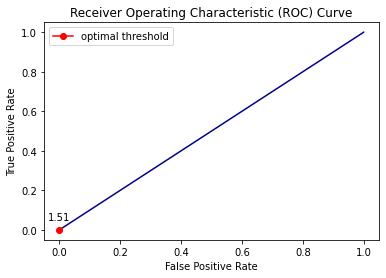

AREA UNDER CURVE (AUC)
0.49999986894355397
OPTIMAL THRESHOLD
151.4038%
OPTIMAL TPR
0.0000%
OPTIMAL FPR
0.0000%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.00
Recall: 0.00
F-Score: 0.00
FOLD 2 TRAINING
Building validation dataset...
Building U-NET Model...
U-NET Model Build Complete.
1015
Starting Cloud Segmentation Model Training...
Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.5358
Epoch 1: val_accuracy improved from -inf to 0.53727, saving model to best_model_20221208120558.h5
101/101 [==============================] - 20s 182ms/step - loss: 0.7059 - accuracy: 0.5358 - val_loss: 0.6930 - val_accuracy: 0.5373
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5300
Epoch 2: val_accuracy improved from 0.53727 to 0.56255, saving model to best_model_20221208120558.h5
101/101 [==============================] - 18s 178ms/step - loss: 0.6929 - accuracy: 0.5300 - val_loss: 0.6926 - val_accuracy: 0.5625
Epoch 3/50
101/101 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5365
Epoch 3: val_accuracy did not improve from 0.56255
1

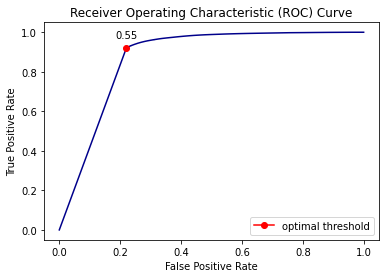

AREA UNDER CURVE (AUC)
0.8703667680829069
OPTIMAL THRESHOLD
54.8014%
OPTIMAL TPR
92.0903%
OPTIMAL FPR
22.0154%
Precision: 0.81
Recall: 0.92
F-Score: 0.86
FOLD 3 TRAINING
Building validation dataset...
Building U-NET Model...
U-NET Model Build Complete.
1015
Starting Cloud Segmentation Model Training...
Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 0.5178 - accuracy: 0.7470
Epoch 1: val_accuracy improved from -inf to 0.82135, saving model to best_model_20221208121345.h5
101/101 [==============================] - 19s 178ms/step - loss: 0.5178 - accuracy: 0.7470 - val_loss: 0.3670 - val_accuracy: 0.8214
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 0.4028 - accuracy: 0.8023
Epoch 2: val_accuracy did not improve from 0.82135
101/101 [==============================] - 17s 171ms/step - loss: 0.4028 - accuracy: 0.8023 - val_loss: 0.4241 - val_accuracy: 0.7974
Epoch 3/50
101/101 [==============================] - ETA: 0s - loss: 0.3708 - accuracy

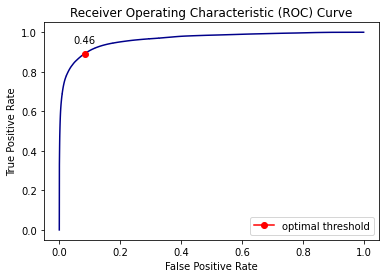

AREA UNDER CURVE (AUC)
0.9639978964098687
OPTIMAL THRESHOLD
45.5770%
OPTIMAL TPR
89.1905%
OPTIMAL FPR
8.3341%
Precision: 0.92
Recall: 0.89
F-Score: 0.91
FOLD 4 TRAINING
Building validation dataset...
Building U-NET Model...
U-NET Model Build Complete.
1015
Starting Cloud Segmentation Model Training...
Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 0.4642 - accuracy: 0.7667
Epoch 1: val_accuracy improved from -inf to 0.82578, saving model to best_model_20221208121734.h5
101/101 [==============================] - 19s 179ms/step - loss: 0.4642 - accuracy: 0.7667 - val_loss: 0.3571 - val_accuracy: 0.8258
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 0.3765 - accuracy: 0.8188
Epoch 2: val_accuracy improved from 0.82578 to 0.82683, saving model to best_model_20221208121734.h5
101/101 [==============================] - 18s 180ms/step - loss: 0.3765 - accuracy: 0.8188 - val_loss: 0.3736 - val_accuracy: 0.8268
Epoch 3/50
101/101 [==================

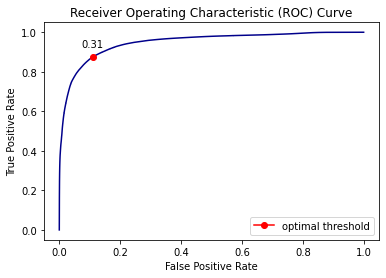

AREA UNDER CURVE (AUC)
0.9479714225453177
OPTIMAL THRESHOLD
30.7500%
OPTIMAL TPR
87.4774%
OPTIMAL FPR
10.9665%
Precision: 0.90
Recall: 0.87
F-Score: 0.89
FOLD 5 TRAINING
Building validation dataset...
Building U-NET Model...
U-NET Model Build Complete.
1015
Starting Cloud Segmentation Model Training...
Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 0.5662 - accuracy: 0.7160
Epoch 1: val_accuracy improved from -inf to 0.80702, saving model to best_model_20221208122104.h5
101/101 [==============================] - 19s 179ms/step - loss: 0.5662 - accuracy: 0.7160 - val_loss: 0.5434 - val_accuracy: 0.8070
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 0.5228 - accuracy: 0.8031
Epoch 2: val_accuracy did not improve from 0.80702
101/101 [==============================] - 17s 171ms/step - loss: 0.5228 - accuracy: 0.8031 - val_loss: 0.5271 - val_accuracy: 0.8064
Epoch 3/50
101/101 [==============================] - ETA: 0s - loss: 0.5023 - accuracy

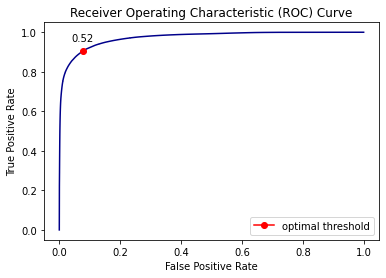

AREA UNDER CURVE (AUC)
0.9729537182522425
OPTIMAL THRESHOLD
52.3868%
OPTIMAL TPR
90.4369%
OPTIMAL FPR
7.7108%
Precision: 0.93
Recall: 0.90
F-Score: 0.92
FOLD 6 TRAINING
Building validation dataset...
Building U-NET Model...
U-NET Model Build Complete.
1015
Starting Cloud Segmentation Model Training...
Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 0.7020 - accuracy: 0.5236
Epoch 1: val_accuracy improved from -inf to 0.50402, saving model to best_model_20221208122910.h5
101/101 [==============================] - 19s 179ms/step - loss: 0.7020 - accuracy: 0.5236 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5273
Epoch 2: val_accuracy improved from 0.50402 to 0.52332, saving model to best_model_20221208122910.h5
101/101 [==============================] - 18s 178ms/step - loss: 0.6930 - accuracy: 0.5273 - val_loss: 0.6929 - val_accuracy: 0.5233
Epoch 3/50
101/101 [==================

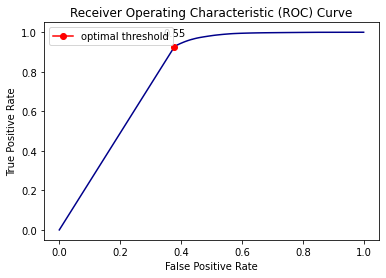

AREA UNDER CURVE (AUC)
0.7910271215410077
OPTIMAL THRESHOLD
54.8818%
OPTIMAL TPR
92.7521%
OPTIMAL FPR
37.8224%
Precision: 0.76
Recall: 0.93
F-Score: 0.83
FOLD 7 TRAINING
Building validation dataset...
Building U-NET Model...
U-NET Model Build Complete.
1015
Starting Cloud Segmentation Model Training...
Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 0.5665 - accuracy: 0.7548
Epoch 1: val_accuracy improved from -inf to 0.81747, saving model to best_model_20221208123900.h5
101/101 [==============================] - 20s 180ms/step - loss: 0.5665 - accuracy: 0.7548 - val_loss: 0.5032 - val_accuracy: 0.8175
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 0.5317 - accuracy: 0.8026
Epoch 2: val_accuracy did not improve from 0.81747
101/101 [==============================] - 17s 171ms/step - loss: 0.5317 - accuracy: 0.8026 - val_loss: 0.5177 - val_accuracy: 0.7879
Epoch 3/50
101/101 [==============================] - ETA: 0s - loss: 0.4951 - accuracy

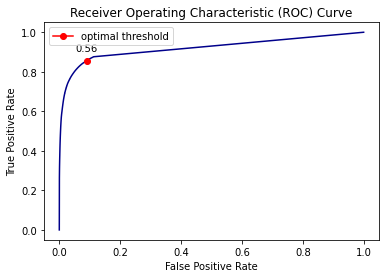

AREA UNDER CURVE (AUC)
0.9197110298967096
OPTIMAL THRESHOLD
55.8490%
OPTIMAL TPR
85.5819%
OPTIMAL FPR
8.9591%
Precision: 0.92
Recall: 0.86
F-Score: 0.89
FOLD 8 TRAINING
Building validation dataset...
Building U-NET Model...
U-NET Model Build Complete.
1015
Starting Cloud Segmentation Model Training...
Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 0.4630 - accuracy: 0.7649
Epoch 1: val_accuracy improved from -inf to 0.79010, saving model to best_model_20221208124353.h5
101/101 [==============================] - 20s 181ms/step - loss: 0.4630 - accuracy: 0.7649 - val_loss: 0.4195 - val_accuracy: 0.7901
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 0.3824 - accuracy: 0.8206
Epoch 2: val_accuracy improved from 0.79010 to 0.81989, saving model to best_model_20221208124353.h5
101/101 [==============================] - 18s 181ms/step - loss: 0.3824 - accuracy: 0.8206 - val_loss: 0.3761 - val_accuracy: 0.8199
Epoch 3/50
101/101 [==================

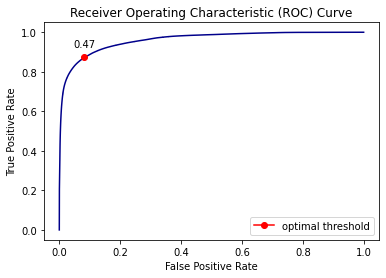

AREA UNDER CURVE (AUC)
0.96088075298511
OPTIMAL THRESHOLD
47.4315%
OPTIMAL TPR
87.2380%
OPTIMAL FPR
8.2325%
Precision: 0.92
Recall: 0.87
F-Score: 0.90
FOLD 9 TRAINING
Building validation dataset...
Building U-NET Model...
U-NET Model Build Complete.
1016
Starting Cloud Segmentation Model Training...
Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.5588
Epoch 1: val_accuracy improved from -inf to 0.74359, saving model to best_model_20221208125000.h5
101/101 [==============================] - 20s 180ms/step - loss: 0.6871 - accuracy: 0.5588 - val_loss: 0.6887 - val_accuracy: 0.7436
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 0.5899 - accuracy: 0.7814
Epoch 2: val_accuracy improved from 0.74359 to 0.81330, saving model to best_model_20221208125000.h5
101/101 [==============================] - 19s 178ms/step - loss: 0.5899 - accuracy: 0.7814 - val_loss: 0.5776 - val_accuracy: 0.8133
Epoch 3/50
101/101 [====================

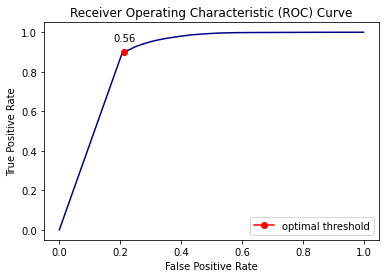

AREA UNDER CURVE (AUC)
0.8741953914167472
OPTIMAL THRESHOLD
55.7159%
OPTIMAL TPR
90.1885%
OPTIMAL FPR
21.3089%
Precision: 0.84
Recall: 0.90
F-Score: 0.87
FOLD 10 TRAINING
Building validation dataset...
Building U-NET Model...
U-NET Model Build Complete.
1016
Starting Cloud Segmentation Model Training...
Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.7147
Epoch 1: val_accuracy improved from -inf to 0.77878, saving model to best_model_20221208125912.h5
101/101 [==============================] - 20s 179ms/step - loss: 0.5283 - accuracy: 0.7147 - val_loss: 0.4251 - val_accuracy: 0.7788
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 0.4120 - accuracy: 0.7951
Epoch 2: val_accuracy improved from 0.77878 to 0.79167, saving model to best_model_20221208125912.h5
101/101 [==============================] - 18s 180ms/step - loss: 0.4120 - accuracy: 0.7951 - val_loss: 0.4328 - val_accuracy: 0.7917
Epoch 3/50
101/101 [================

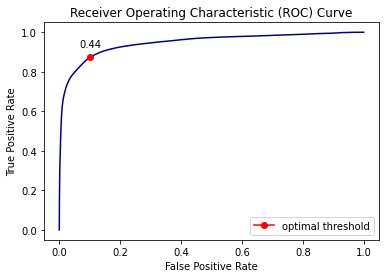

AREA UNDER CURVE (AUC)
0.9459939305671261
OPTIMAL THRESHOLD
44.3085%
OPTIMAL TPR
87.3510%
OPTIMAL FPR
10.1517%
Precision: 0.91
Recall: 0.87
F-Score: 0.89


In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=42)

fold = 1
for train_index, test_index in kf.split(cloud_data, cloudGT_data):

    print("FOLD "+str(fold)+" TRAINING")
    cloudseg_model = train_cloudseg_model(cloud_data[train_index], cloudGT_data[train_index])
    print("FOLD "+str(fold)+" MODEL EVALUATION")
    eval_cloudseg_model(cloudseg_model, cloud_data[test_index], cloudGT_data[test_index])
    fold += 1